<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DATA-IMPORT-+-TARGET-REDESIGN-AND-FINAL-FEATURE-ENGINEERING" data-toc-modified-id="DATA-IMPORT-+-TARGET-REDESIGN-AND-FINAL-FEATURE-ENGINEERING-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DATA IMPORT + TARGET REDESIGN AND FINAL FEATURE ENGINEERING</a></span></li><li><span><a href="#CORRELATION-ANALYSIS" data-toc-modified-id="CORRELATION-ANALYSIS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>CORRELATION ANALYSIS</a></span></li><li><span><a href="#SHAP-+--FEATURE-IMPORTANCES-SELECTION-WITH-CONSERVATIVE-LGBMREGRESSOR-MODEL" data-toc-modified-id="SHAP-+--FEATURE-IMPORTANCES-SELECTION-WITH-CONSERVATIVE-LGBMREGRESSOR-MODEL-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SHAP +  FEATURE IMPORTANCES SELECTION WITH CONSERVATIVE LGBMREGRESSOR MODEL</a></span></li><li><span><a href="#HYPERPARAM-SEARCH" data-toc-modified-id="HYPERPARAM-SEARCH-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>HYPERPARAM SEARCH</a></span></li><li><span><a href="#DUMMY-REGRESSOR-VS-CHOSEN-MODELS-PERFORMANCES-OF-TEST-DATA" data-toc-modified-id="DUMMY-REGRESSOR-VS-CHOSEN-MODELS-PERFORMANCES-OF-TEST-DATA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DUMMY REGRESSOR VS CHOSEN MODELS PERFORMANCES OF TEST DATA</a></span></li><li><span><a href="#LGBM-PLOTTING-API" data-toc-modified-id="LGBM-PLOTTING-API-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LGBM PLOTTING API</a></span></li></ul></div>

In [2]:
import sys
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm
from lightgbm import LGBMRegressor, plot_importance, create_tree_digraph
from matplotlib import style
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import  mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

sys.path.append('/home/dsuser/Furkan/RLP/py_files')
# custom modules 
import importances
from importances import Importances
import optimize_grid 
from optimize_grid import grid_search_results_optimization, test_performances

pd.set_option("display.max_columns", None)
style.use("seaborn")
warnings.filterwarnings("ignore")

### DATA IMPORT + TARGET REDESIGN AND FINAL FEATURE ENGINEERING

In [3]:
%%time
X_train = pd.read_pickle("./data/nb3_output_digital_X_train.pickle") 

X_test = pd.read_pickle("./data/nb3_output_digital_X_test.pickle") 

y_train = pd.read_pickle("./data/nb2_output_digital_y_train.pickle")

y_test = pd.read_pickle("./data/nb2_output_digital_y_test.pickle")

X_train.shape, y_train.shape, X_test.shape, y_test.shape

CPU times: user 3.93 s, sys: 19.3 s, total: 23.2 s
Wall time: 43.8 s


((1230096, 2920), (1230096,), (544996, 2920), (544996,))

In [4]:
X_train.head(2)

AST_62_M1  CUS_071_M1  CUS_074_M1  CUS_075_M1  CUS_076_M1  \
BRYKRDTEKLIFNO                                                              
51541349         0.026733    0.026559    0.026794    0.025528    0.026779   
48591384         0.026733    0.026559    0.026794    0.025528    0.026779   

                CUS_078_M1  CUS_081_M1  CUS_082_M1  CUS_084_M1  CUS_094_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.030579    0.025308    0.026131    0.030155    0.030974   
48591384          0.030579    0.025308    0.026131         NaN    0.022974   

                CUS_095_M1  CUS_096_M1  CUS_097_M1  CUS_105_M1  CUS_106_M1  \
BRYKRDTEKLIFNO                                                               
51541349           0.02626    0.026321    0.023553    0.026962    0.026208   
48591384           0.02626    0.026321    0.023666    0.026962    0.026208   

                CUS_111_M1  CUS_113_M1  CUS_115_M1  CUS_116_M1  CUS_124_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.026199    0.024323    0.022125    0.025955     0.02681   
48591384          0.026199    0.024323    0.032166    0.025955     0.02681   

                CUS_127_M1  KKB_142_M1  KKB_248_M1  KKB_249_M1  KKB_251_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.026932    0.026901    0.026947    0.026962    0.026596   
48591384          0.026932    0.026901    0.026947    0.026962    0.026596   

                LIM_25_M1  LIM_25_1_M1  PAY_029_M1  PAY_030_M1  RSK_003_M1  \
BRYKRDTEKLIFNO                                                               
51541349         0.026291          NaN    0.023895    0.026886    0.027084   
48591384              NaN          NaN         NaN    0.026886    0.027084   

                RSK_005_M1  CUS_069_M1  CUS_108_M1  CUS_109_M1  CUS_093_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.027328    0.015031    0.027707    0.027378    41.96875   
48591384          0.027328    0.029691    0.021450    0.027378    37.87500   

                CUS_122_M1  AUT_050_M1  AUT_050_1_M1  AUT_051_M1  \
BRYKRDTEKLIFNO                                                     
51541349         50.750000         0.0           NaN    0.170044   
48591384         19.609375         NaN           NaN         NaN   

                AUT_051_1_M1  AUT_053_M1  AUT_054_M1  AUT_055_M1  AUT_110_M1  \
BRYKRDTEKLIFNO                                                                 
51541349                 1.0         0.0         0.0         1.0         NaN   
48591384                 NaN         NaN         NaN         NaN         NaN   

                AUT_110_1_M1  AUT_111_M1  AUT_111_1_M1  AUT_113_M1  \
BRYKRDTEKLIFNO                                                       
51541349                 NaN         NaN           NaN         NaN   
48591384                 NaN         NaN           NaN         NaN   

                AUT_114_M1  AUT_115_M1  CUS_077_M1  CUS_079_M1  CUS_121_M1  \
BRYKRDTEKLIFNO                                                               
51541349               NaN         NaN         NaN    0.021013         1.0   
48591384               NaN         NaN         NaN    0.024589         NaN   

                KKB_138_M1  KKB_139_M1  KKB_145_M1  KKB_146_M1  KKB_148_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.034838    0.036518         0.0         1.0         0.0   
48591384          0.034838    0.036518         2.0         2.0         0.0   

                KKB_149_M1  KKB_151_M1  KKB_152_M1  KKB_163_M1  KKB_164_M1  \
BRYKRDTEKLIFNO                                                               
51541349               0.0         0.0         0.0    0.038789    0.021779   
48591384               0.0         0.0         0.0    0.018133    0.021779   

               

In [5]:
y_train.head(2)

BRYKRDTEKLIFNO
54781717   -0.146524
43772543    0.143579
Name: SENSITIVITY, dtype: float64

In [6]:
X_test.head(2)

AST_62_M1  CUS_071_M1  CUS_074_M1  CUS_075_M1  CUS_076_M1  \
BRYKRDTEKLIFNO                                                              
61470246         0.026733    0.026559    0.026794    0.030167    0.026779   
67024420         0.026733    0.026559    0.026794    0.030167    0.026779   

                CUS_078_M1  CUS_081_M1  CUS_082_M1  CUS_084_M1  CUS_094_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.030579    0.039689    0.028134         NaN         NaN   
67024420          0.018921    0.028069    0.028134         NaN     0.02833   

                CUS_095_M1  CUS_096_M1  CUS_097_M1  CUS_105_M1  CUS_106_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.031769    0.032806         NaN    0.026962    0.026208   
67024420          0.026260    0.026321    0.025335    0.026962    0.026208   

                CUS_111_M1  CUS_113_M1  CUS_115_M1  CUS_116_M1  CUS_124_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.026199    0.024323    0.022125    0.025955     0.02681   
67024420          0.026199    0.024323    0.032166    0.025955     0.02681   

                CUS_127_M1  KKB_142_M1  KKB_248_M1  KKB_249_M1  KKB_251_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.026932    0.026901    0.026947     0.02655    0.026596   
67024420          0.026932    0.026901    0.026947     0.02655    0.026596   

                LIM_25_M1  LIM_25_1_M1  PAY_029_M1  PAY_030_M1  RSK_003_M1  \
BRYKRDTEKLIFNO                                                               
61470246         0.034943          NaN         NaN    0.026886    0.027084   
67024420              NaN          NaN         NaN    0.026886         NaN   

                RSK_005_M1  CUS_069_M1  CUS_108_M1  CUS_109_M1  CUS_093_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.027328    0.013257     0.02145    0.027378    2.230469   
67024420          0.027328    0.014382     0.02145    0.027378   29.265625   

                CUS_122_M1  AUT_050_M1  AUT_050_1_M1  AUT_051_M1  \
BRYKRDTEKLIFNO                                                     
61470246               5.0    3.330078      3.330078    2.669922   
67024420               NaN         NaN           NaN         NaN   

                AUT_051_1_M1  AUT_053_M1  AUT_054_M1  AUT_055_M1  AUT_110_M1  \
BRYKRDTEKLIFNO                                                                 
61470246                 4.0         1.0        10.0        16.0    3.669922   
67024420                 NaN         NaN         NaN         NaN         NaN   

                AUT_110_1_M1  AUT_111_M1  AUT_111_1_M1  AUT_113_M1  \
BRYKRDTEKLIFNO                                                       
61470246            3.669922    2.169922          3.25         2.0   
67024420                 NaN         NaN           NaN         NaN   

                AUT_114_M1  AUT_115_M1  CUS_077_M1  CUS_079_M1  CUS_121_M1  \
BRYKRDTEKLIFNO                                                               
61470246              11.0        13.0         NaN    0.030128         1.0   
67024420               NaN         NaN         NaN    0.036257         NaN   

                KKB_138_M1  KKB_139_M1  KKB_145_M1  KKB_146_M1  KKB_148_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.034838    0.020728         1.0         3.0         0.0   
67024420          0.012943    0.036518         3.0         3.0         0.0   

                KKB_149_M1  KKB_151_M1  KKB_152_M1  KKB_163_M1  KKB_164_M1  \
BRYKRDTEKLIFNO                                                               
61470246               0.0         0.0         0.0    0.018133    0.021779   
67024420               0.0         0.0         0.0    0.018133    0.021779   

               

In [7]:
y_test.head(2)

BRYKRDTEKLIFNO
60962741   -0.075652
59754340   -0.129194
Name: SENSITIVITY, dtype: float64

**INDEXLERI DUZELTELIM**

In [4]:
df = pd.concat( [X_train, y_train], axis = 1, join = "inner")

X_train = df.drop("SENSITIVITY", axis = 1)

y_train = df["SENSITIVITY"]

del df 

X_train.shape, y_train.shape

((1230096, 2920), (1230096,))

In [5]:
df = pd.concat( [X_test, y_test], axis = 1, join = "inner")

X_test = df.drop("SENSITIVITY", axis = 1)

y_test = df["SENSITIVITY"]

del df 

X_test.shape, y_test.shape

((544996, 2920), (544996,))

In [10]:
X_train.head(2)

AST_62_M1  CUS_071_M1  CUS_074_M1  CUS_075_M1  CUS_076_M1  \
BRYKRDTEKLIFNO                                                              
51541349         0.026733    0.026559    0.026794    0.025528    0.026779   
48591384         0.026733    0.026559    0.026794    0.025528    0.026779   

                CUS_078_M1  CUS_081_M1  CUS_082_M1  CUS_084_M1  CUS_094_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.030579    0.025308    0.026131    0.030155    0.030974   
48591384          0.030579    0.025308    0.026131         NaN    0.022974   

                CUS_095_M1  CUS_096_M1  CUS_097_M1  CUS_105_M1  CUS_106_M1  \
BRYKRDTEKLIFNO                                                               
51541349           0.02626    0.026321    0.023553    0.026962    0.026208   
48591384           0.02626    0.026321    0.023666    0.026962    0.026208   

                CUS_111_M1  CUS_113_M1  CUS_115_M1  CUS_116_M1  CUS_124_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.026199    0.024323    0.022125    0.025955     0.02681   
48591384          0.026199    0.024323    0.032166    0.025955     0.02681   

                CUS_127_M1  KKB_142_M1  KKB_248_M1  KKB_249_M1  KKB_251_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.026932    0.026901    0.026947    0.026962    0.026596   
48591384          0.026932    0.026901    0.026947    0.026962    0.026596   

                LIM_25_M1  LIM_25_1_M1  PAY_029_M1  PAY_030_M1  RSK_003_M1  \
BRYKRDTEKLIFNO                                                               
51541349         0.026291          NaN    0.023895    0.026886    0.027084   
48591384              NaN          NaN         NaN    0.026886    0.027084   

                RSK_005_M1  CUS_069_M1  CUS_108_M1  CUS_109_M1  CUS_093_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.027328    0.015031    0.027707    0.027378    41.96875   
48591384          0.027328    0.029691    0.021450    0.027378    37.87500   

                CUS_122_M1  AUT_050_M1  AUT_050_1_M1  AUT_051_M1  \
BRYKRDTEKLIFNO                                                     
51541349         50.750000         0.0           NaN    0.170044   
48591384         19.609375         NaN           NaN         NaN   

                AUT_051_1_M1  AUT_053_M1  AUT_054_M1  AUT_055_M1  AUT_110_M1  \
BRYKRDTEKLIFNO                                                                 
51541349                 1.0         0.0         0.0         1.0         NaN   
48591384                 NaN         NaN         NaN         NaN         NaN   

                AUT_110_1_M1  AUT_111_M1  AUT_111_1_M1  AUT_113_M1  \
BRYKRDTEKLIFNO                                                       
51541349                 NaN         NaN           NaN         NaN   
48591384                 NaN         NaN           NaN         NaN   

                AUT_114_M1  AUT_115_M1  CUS_077_M1  CUS_079_M1  CUS_121_M1  \
BRYKRDTEKLIFNO                                                               
51541349               NaN         NaN         NaN    0.021013         1.0   
48591384               NaN         NaN         NaN    0.024589         NaN   

                KKB_138_M1  KKB_139_M1  KKB_145_M1  KKB_146_M1  KKB_148_M1  \
BRYKRDTEKLIFNO                                                               
51541349          0.034838    0.036518         0.0         1.0         0.0   
48591384          0.034838    0.036518         2.0         2.0         0.0   

                KKB_149_M1  KKB_151_M1  KKB_152_M1  KKB_163_M1  KKB_164_M1  \
BRYKRDTEKLIFNO                                                               
51541349               0.0         0.0         0.0    0.038789    0.021779   
48591384               0.0         0.0         0.0    0.018133    0.021779   

               

In [11]:
y_train.head(2)

BRYKRDTEKLIFNO
51541349    0.049307
48591384    0.036340
Name: SENSITIVITY, dtype: float64

In [12]:
X_test.head(2)

AST_62_M1  CUS_071_M1  CUS_074_M1  CUS_075_M1  CUS_076_M1  \
BRYKRDTEKLIFNO                                                              
61470246         0.026733    0.026559    0.026794    0.030167    0.026779   
67024420         0.026733    0.026559    0.026794    0.030167    0.026779   

                CUS_078_M1  CUS_081_M1  CUS_082_M1  CUS_084_M1  CUS_094_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.030579    0.039689    0.028134         NaN         NaN   
67024420          0.018921    0.028069    0.028134         NaN     0.02833   

                CUS_095_M1  CUS_096_M1  CUS_097_M1  CUS_105_M1  CUS_106_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.031769    0.032806         NaN    0.026962    0.026208   
67024420          0.026260    0.026321    0.025335    0.026962    0.026208   

                CUS_111_M1  CUS_113_M1  CUS_115_M1  CUS_116_M1  CUS_124_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.026199    0.024323    0.022125    0.025955     0.02681   
67024420          0.026199    0.024323    0.032166    0.025955     0.02681   

                CUS_127_M1  KKB_142_M1  KKB_248_M1  KKB_249_M1  KKB_251_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.026932    0.026901    0.026947     0.02655    0.026596   
67024420          0.026932    0.026901    0.026947     0.02655    0.026596   

                LIM_25_M1  LIM_25_1_M1  PAY_029_M1  PAY_030_M1  RSK_003_M1  \
BRYKRDTEKLIFNO                                                               
61470246         0.034943          NaN         NaN    0.026886    0.027084   
67024420              NaN          NaN         NaN    0.026886         NaN   

                RSK_005_M1  CUS_069_M1  CUS_108_M1  CUS_109_M1  CUS_093_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.027328    0.013257     0.02145    0.027378    2.230469   
67024420          0.027328    0.014382     0.02145    0.027378   29.265625   

                CUS_122_M1  AUT_050_M1  AUT_050_1_M1  AUT_051_M1  \
BRYKRDTEKLIFNO                                                     
61470246               5.0    3.330078      3.330078    2.669922   
67024420               NaN         NaN           NaN         NaN   

                AUT_051_1_M1  AUT_053_M1  AUT_054_M1  AUT_055_M1  AUT_110_M1  \
BRYKRDTEKLIFNO                                                                 
61470246                 4.0         1.0        10.0        16.0    3.669922   
67024420                 NaN         NaN         NaN         NaN         NaN   

                AUT_110_1_M1  AUT_111_M1  AUT_111_1_M1  AUT_113_M1  \
BRYKRDTEKLIFNO                                                       
61470246            3.669922    2.169922          3.25         2.0   
67024420                 NaN         NaN           NaN         NaN   

                AUT_114_M1  AUT_115_M1  CUS_077_M1  CUS_079_M1  CUS_121_M1  \
BRYKRDTEKLIFNO                                                               
61470246              11.0        13.0         NaN    0.030128         1.0   
67024420               NaN         NaN         NaN    0.036257         NaN   

                KKB_138_M1  KKB_139_M1  KKB_145_M1  KKB_146_M1  KKB_148_M1  \
BRYKRDTEKLIFNO                                                               
61470246          0.034838    0.020728         1.0         3.0         0.0   
67024420          0.012943    0.036518         3.0         3.0         0.0   

                KKB_149_M1  KKB_151_M1  KKB_152_M1  KKB_163_M1  KKB_164_M1  \
BRYKRDTEKLIFNO                                                               
61470246               0.0         0.0         0.0    0.018133    0.021779   
67024420               0.0         0.0         0.0    0.018133    0.021779   

               

In [13]:
y_test.head(2)

BRYKRDTEKLIFNO
61470246    0.064502
67024420   -0.225169
Name: SENSITIVITY, dtype: float64

In [6]:
#  check non-numeric columns in both train and test.

print(X_train.select_dtypes(exclude = "number").columns.tolist(),X_test.select_dtypes(exclude = "number").columns.tolist())

[] []


In [7]:
# target feature datasetlerinde yer almasın ( control )

"SENSITIVITY" in X_train, "SENSITIVITY" in X_test

(False, False)

**correlations control**

In [8]:
df = pd.concat([X_train, y_train], axis = 1, join = "inner")

print(abs(df["NBSM_PAR_404"].corr(df["SENSITIVITY"], method = "pearson")))

print(abs(df["NBSM_PAR_3315"].corr(df["SENSITIVITY"], method = "pearson")))

# print(abs(df["NBSM_PAR_453"].corr(df["SENSITIVITY"], method = "pearson")))

del df

0.32355479814280486
0.1758472549344165


**TARGET REDESIGN -- SUCH THAT MINIMUM VALUE IS 1 -- FOR MAPE METRIC EXPLAINABILITY**

<AxesSubplot:>

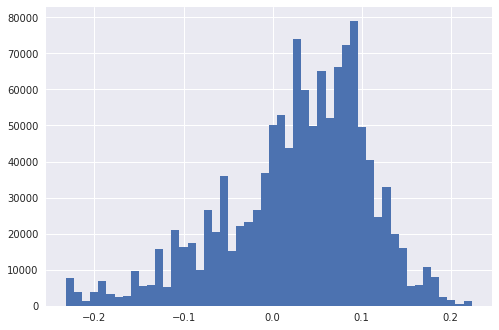

In [17]:
y_train.hist(bins = 50)

<AxesSubplot:ylabel='Density'>

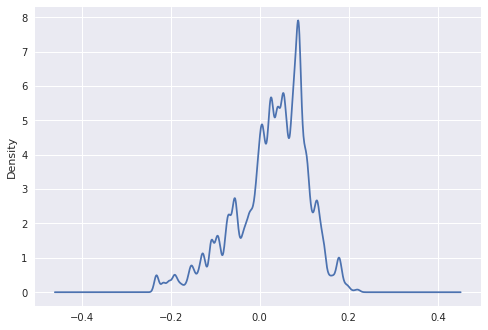

In [18]:
y_train.plot.kde()

<AxesSubplot:>

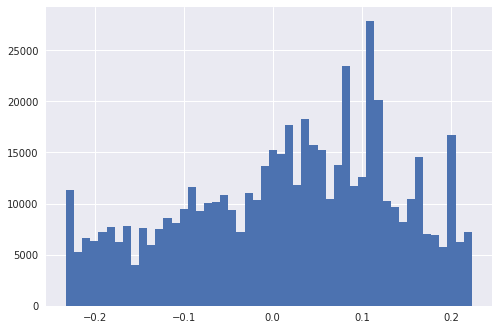

In [19]:
y_test.hist(bins = 50)

<AxesSubplot:ylabel='Density'>

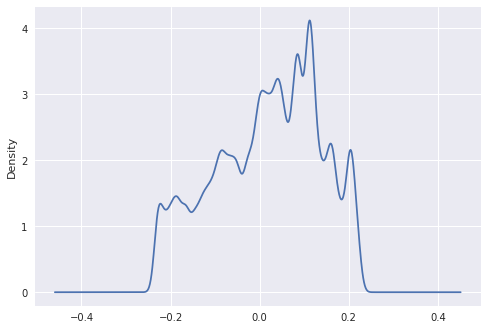

In [20]:
y_test.plot.kde()

In [9]:
min_val = y_train.min()

print(round(y_train.min(),4), round(y_test.min(),4))

y_train = (y_train - min_val) + 1

y_test = (y_test - min_val) + 1

print(round(y_train.min(),2), round(y_test.min(),2))

-0.2321 -0.232
1.0 1.0


<AxesSubplot:>

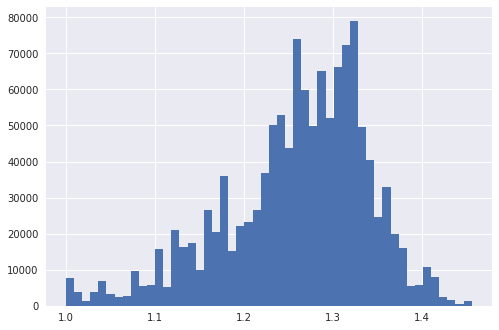

In [22]:
y_train.hist(bins = 50)

<AxesSubplot:ylabel='Density'>

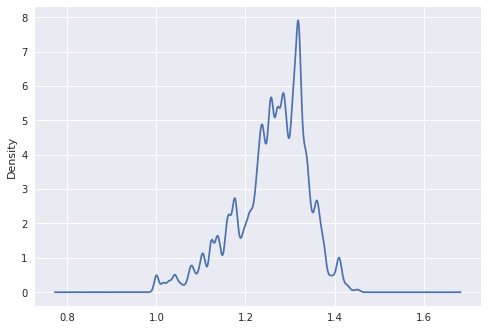

In [23]:
y_train.plot.kde()

<AxesSubplot:>

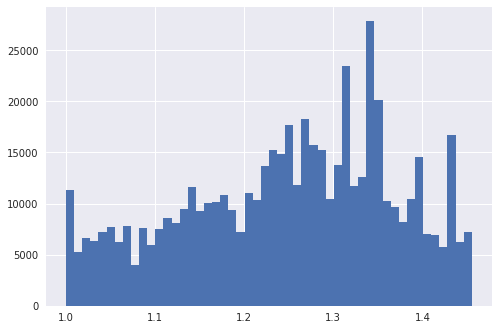

In [24]:
y_test.hist(bins = 50)

<AxesSubplot:ylabel='Density'>

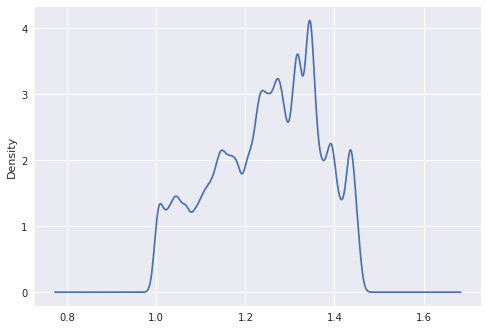

In [25]:
y_test.plot.kde()

In [26]:
y_train.head(3)

BRYKRDTEKLIFNO
51541349    1.281384
48591384    1.268417
58095688    1.375801
Name: SENSITIVITY, dtype: float64

In [10]:
df = pd.concat([X_train, y_train], axis = 1, join = "inner")

print(abs(df["NBSM_PAR_404"].corr(df["SENSITIVITY"], method = "pearson")))

print(abs(df["NBSM_PAR_3315"].corr(df["SENSITIVITY"], method = "pearson")))

# print(abs(df["NBSM_PAR_453"].corr(df["SENSITIVITY"], method = "pearson")))

del df

0.32355479814280486
0.1758472549344165


### CORRELATION ANALYSIS

**CORRELATION ANALYSIS -- FIND FEATURES THAT ARE HIGHLY CORRELATED WITH TARGET -- METHOD : PEARSON**

In [28]:
corrs = {}

df = pd.concat([X_train, y_train], axis = 1, join = "inner")

for col in df.columns:
    
    if col != "SENSITIVITY":
        
        corr_value = abs(df[col].corr(df["SENSITIVITY"], method = "pearson"))
        
        corrs.update( { col : corr_value } )        
        
del df

In [29]:
corrs_df = pd.DataFrame.from_dict(corrs, orient = "index")

corrs_df.rename( columns = { 0 : "corr"}, inplace = True)

corrs_df.sort_values("corr", ascending = False, inplace = True)

corrs_df.shape

(2920, 1)

In [30]:
corrs_df.head(30)

,corr
NBSM_PAR_404,0.323555
KKB_256_M1,0.239205
SAS_1_M1,0.176796
NBSM_PAR_3315,0.175847
SCORE_1_3_M1,0.166238
NBSM_PAR_3329,0.165276
RSK_PYM_OPN_CRD_STS_EVER,0.158537
NBSM_PAR_1172,0.157399
RSK_PYM_WPS_M24,0.155780
KKB_167_M1,0.155414


In [29]:
corrs_df2.head(10) # OLD DATA CORRELATIONS --- ikinci versiyon -- elifin çıktığı data

,corr
O_C_OTOMOTIV_C_M2,0.004726
C_BENZIN_ISTASYONU_M2M3,0.004592
PAY_026_3_M1M2,0.004465
PAY_020_M1M2,0.004465
CRD_HNG_SEQ_APP_CC_M6_D15,0.004109
O_C_BILGISAYAR_C_M2,0.004090
CRD_HNG_SEQ_APP_CC_M12_D15,0.004087
CRD_HNG_SEQ_APP_CC_M9_D15,0.004087
CRD_HNG_SEQ_APP_CC_M5_D15,0.004053
AUT_122_M1M2,0.003975


In [21]:
corrs_df2.head(10)  # OLD DATA CORRELATIONS --- ilk versiyon -- furkanın çıktıgı data

,corr
NBSM_PAR_3695,0.006483
ODEME_KANALI,0.006072
NBSM_PAR_2908,0.004490
I_PAY_UTL_FSTPUR_DUR,0.004460
PAY_016_M2,0.004425
EKS_NAK_BKY_YD_M2,0.004198
A_NTAKSIT_M1,0.004095
C_HIZMET_M2,0.004086
A_OTOMOTIV_M2,0.004073
NBSM_PAR_5149,0.004034


**Persistance of Correlation Analysis Results**

In [31]:
%%time
joblib.dump(corrs_df, "./outputs2/corr_df_pearson.joblib")

CPU times: user 3.35 ms, sys: 102 µs, total: 3.45 ms
Wall time: 2.57 ms


['./outputs2/corr_df_pearson.joblib']

### SHAP +  FEATURE IMPORTANCES SELECTION WITH CONSERVATIVE LGBMREGRESSOR MODEL

In [61]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1230096, 2920), (1230096,), (544996, 2920), (544996,))

In [62]:
import importlib 
importlib.reload(importances)

import importances
from importances import Importances

In [63]:
model = LGBMRegressor(random_state=2023,
                      subsample_for_bin=50000,
                      max_depth=4,
                      n_estimators=200,
                      num_leaves=100,
                      reg_alpha=0.5,
                      reg_lambda=0.5,
                      learning_rate=0.05,
                      importance_type="gain")

model

LGBMRegressor(importance_type='gain', learning_rate=0.05, max_depth=4,
              n_estimators=200, num_leaves=100, random_state=2023,
              reg_alpha=0.5, reg_lambda=0.5, subsample_for_bin=50000)

In [64]:
imp = Importances(model, X_train.iloc[:200000, :], y_train.iloc[:200000], n_features = 50)

In [65]:
imp.fit()

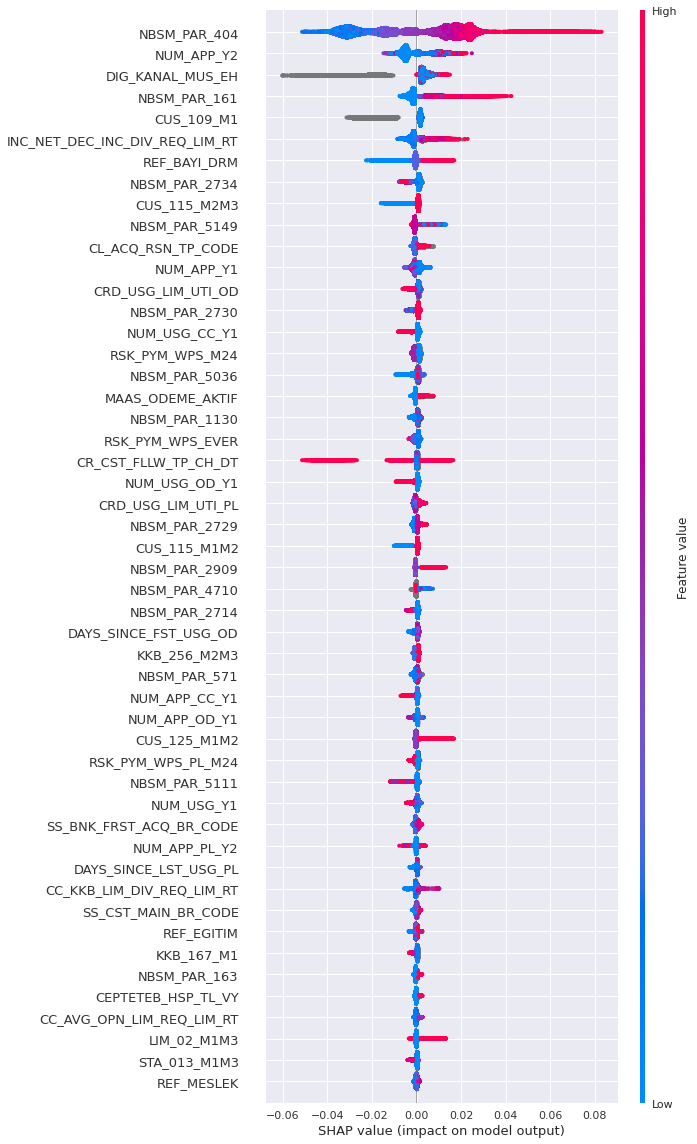

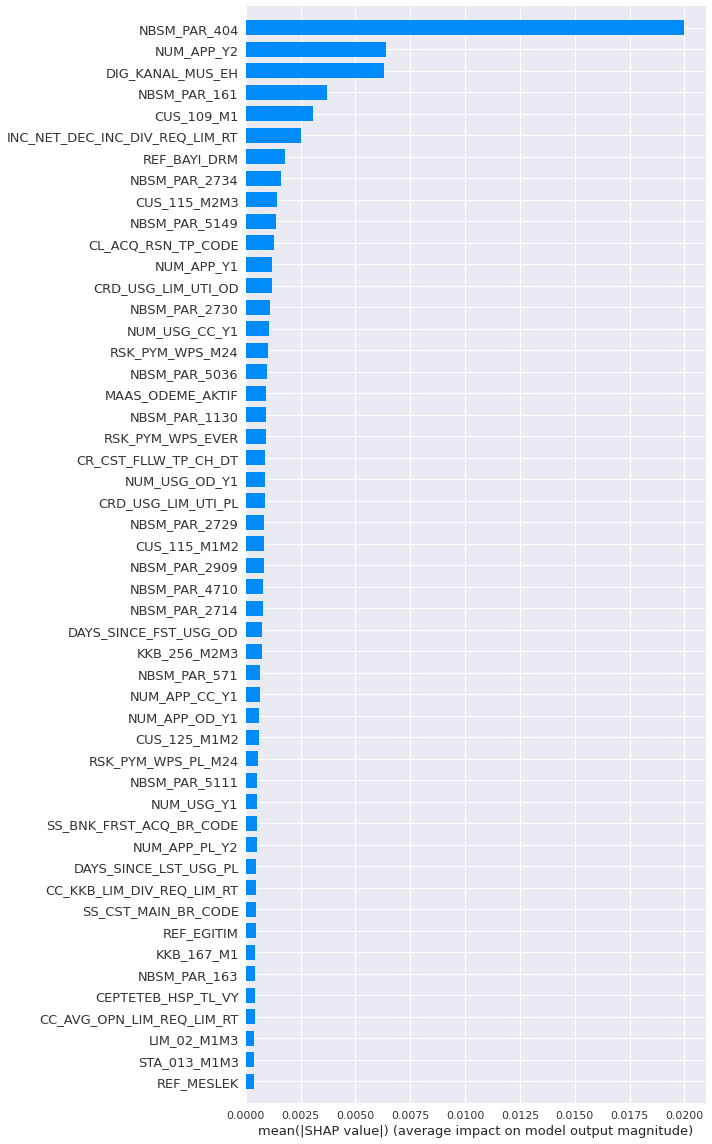

In [66]:
imp.shap_values()

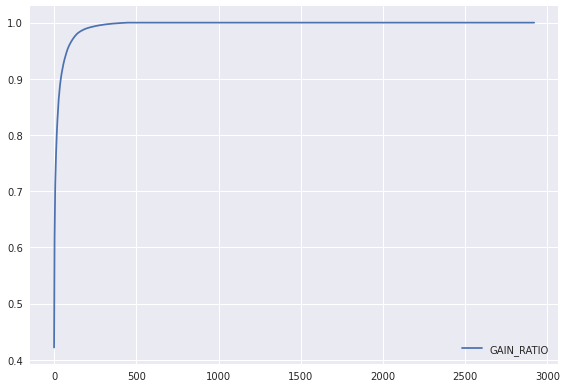

In [67]:
df_model = imp.feature_importances()

In [73]:
df_model.head(30) ## MODEL.FEATURE_IMPORTANCES() DUZELMIS....

,IMPORTANCE,CUMSUM,GAIN_RATIO
NBSM_PAR_404,1520.066879,1520.066879,0.421710
DIG_KANAL_MUS_EH,298.632490,1818.699370,0.504559
NUM_APP_Y2,253.823123,2072.522493,0.574977
NBSM_PAR_161,150.425262,2222.947755,0.616710
INC_NET_DEC_INC_DIV_REQ_LIM_RT,96.057534,2319.005288,0.643359
CUS_109_M1,84.307658,2403.312946,0.666748
CR_CST_FLLW_TP_CH_DT,81.646284,2484.959230,0.689399
REF_BAYI_DRM,81.159201,2566.118431,0.711915
CL_ACQ_RSN_TP_CODE,43.893859,2610.012290,0.724092
CUS_115_M2M3,40.978144,2650.990434,0.735461


In [91]:
#df_model.head(50).to_pickle("./data/top50_features_with_importance_and_gain_scores.pickle") 

In [72]:
# final_features = imp.final_feature_selection()

In [71]:
#len(final_features)

### HYPERPARAM SEARCH

In [60]:
model = LGBMRegressor(random_state = 2023)

In [61]:
param_grid = { "max_depth" : [2,3,4,5,6],
               "num_leaves" : [20,30,40],
               "learning_rate" : [0.01, 0.05, 0.1],
               "n_estimators" : [100,200],
               "reg_alpha" : [0.25, 0.75],
               "reg_lambda" : [0.25, 0.75] }

In [62]:
 # rami boşaltmak adına -- grid search için :
#del train
#del test

In [63]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1230096, 2920), (1230096,), (544996, 2920), (544996,))

In [64]:
"SENSITIVITY" in X_train

False

In [65]:
X_train[final_features].shape

(1230096, 98)

In [66]:
%%time
model.fit(X_train[final_features], y_train)   # single fit ( what is fit time complexity ? )

CPU times: user 2min 27s, sys: 6.12 s, total: 2min 33s
Wall time: 6.04 s


LGBMRegressor(random_state=2023)

In [67]:
gs = GridSearchCV(model,
                  param_grid,
                  scoring= "neg_mean_absolute_percentage_error",
                  n_jobs=1,
                  cv=3,
                  verbose=10)

In [68]:
%%time
gs.fit(X_train[final_features], y_train)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[CV 1/3; 1/360] START learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 1/3; 1/360] END learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.048 total time=   3.8s
[CV 2/3; 1/360] START learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 1/360] END learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.049 total time=   3.5s
[CV 3/3; 1/360] START learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 1/360] END learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.049 total time=   4.2s
[CV 1/3; 2/360] START learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75


[CV 1/3; 11/360] END learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.048 total time=   4.8s
[CV 2/3; 11/360] START learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 11/360] END learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.049 total time=   4.8s
[CV 3/3; 11/360] START learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 11/360] END learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.049 total time=   4.5s
[CV 1/3; 12/360] START learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 12/360] END learning_rate=0.01, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75;, score=-0.048 total time=   4.5s
[CV 2/3; 12/360] START le

[CV 1/3; 21/360] END learning_rate=0.01, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.048 total time=   7.5s
[CV 2/3; 21/360] START learning_rate=0.01, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 21/360] END learning_rate=0.01, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.048 total time=   6.1s
[CV 3/3; 21/360] START learning_rate=0.01, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 21/360] END learning_rate=0.01, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.048 total time=   6.2s
[CV 1/3; 22/360] START learning_rate=0.01, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 22/360] END learning_rate=0.01, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75;, score=-0.048 total time=   6.3s
[CV 2/3; 22/360] START le

[CV 1/3; 31/360] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.048 total time=   4.9s
[CV 2/3; 31/360] START learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 31/360] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.048 total time=   4.4s
[CV 3/3; 31/360] START learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 31/360] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.048 total time=   3.9s
[CV 1/3; 32/360] START learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 32/360] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75;, score=-0.048 total time=   4.1s
[CV 2/3; 32/360] START le

[CV 1/3; 41/360] END learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.047 total time=   5.1s
[CV 2/3; 41/360] START learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 41/360] END learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.047 total time=   5.2s
[CV 3/3; 41/360] START learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 41/360] END learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.047 total time=   5.7s
[CV 1/3; 42/360] START learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 42/360] END learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75;, score=-0.047 total time=   5.4s
[CV 2/3; 42/360] START le

[CV 1/3; 51/360] END learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.047 total time=   5.5s
[CV 2/3; 51/360] START learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 51/360] END learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.047 total time=   6.1s
[CV 3/3; 51/360] START learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 51/360] END learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.047 total time=   5.8s
[CV 1/3; 52/360] START learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 52/360] END learning_rate=0.01, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75;, score=-0.047 total time=   5.7s
[CV 2/3; 52/360] START le

[CV 1/3; 61/360] END learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.046 total time=   6.4s
[CV 2/3; 61/360] START learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 61/360] END learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.046 total time=   6.2s
[CV 3/3; 61/360] START learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 61/360] END learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.046 total time=   6.2s
[CV 1/3; 62/360] START learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 62/360] END learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75;, score=-0.046 total time=   6.3s
[CV 2/3; 62/360] START le

[CV 1/3; 71/360] END learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.046 total time=   5.8s
[CV 2/3; 71/360] START learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 71/360] END learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.046 total time=   7.0s
[CV 3/3; 71/360] START learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 71/360] END learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.046 total time=   7.9s
[CV 1/3; 72/360] START learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 72/360] END learning_rate=0.01, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75;, score=-0.046 total time=   7.6s
[CV 2/3; 72/360] START le

[CV 1/3; 81/360] END learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.047 total time=   6.7s
[CV 2/3; 81/360] START learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 81/360] END learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.047 total time=   6.3s
[CV 3/3; 81/360] START learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 81/360] END learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.047 total time=   6.6s
[CV 1/3; 82/360] START learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 82/360] END learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75;, score=-0.047 total time=   6.5s
[CV 2/3; 82/360] START le

[CV 1/3; 91/360] END learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   7.6s
[CV 2/3; 91/360] START learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 91/360] END learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   6.9s
[CV 3/3; 91/360] START learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 91/360] END learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   9.5s
[CV 1/3; 92/360] START learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 92/360] END learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75;, score=-0.045 total time=  10.0s
[CV 2/3; 92/360] START le

[CV 1/3; 101/360] END learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.046 total time=   5.1s
[CV 2/3; 101/360] START learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 101/360] END learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.047 total time=   5.4s
[CV 3/3; 101/360] START learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 101/360] END learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.047 total time=   5.4s
[CV 1/3; 102/360] START learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 102/360] END learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75;, score=-0.046 total time=   6.0s
[CV 2/3; 102/360] 

[CV 1/3; 111/360] END learning_rate=0.01, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   7.5s
[CV 2/3; 111/360] START learning_rate=0.01, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 111/360] END learning_rate=0.01, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   7.6s
[CV 3/3; 111/360] START learning_rate=0.01, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 111/360] END learning_rate=0.01, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   7.2s
[CV 1/3; 112/360] START learning_rate=0.01, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 112/360] END learning_rate=0.01, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75;, score=-0.045 total time=   7.9s
[CV 2/3; 112/360] 

[CV 1/3; 121/360] END learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.046 total time=   3.7s
[CV 2/3; 121/360] START learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 121/360] END learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.046 total time=   3.6s
[CV 3/3; 121/360] START learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 121/360] END learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.046 total time=   3.8s
[CV 1/3; 122/360] START learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 122/360] END learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75;, score=-0.046 total time=   3.9s
[CV 2/3; 122/360] 

[CV 1/3; 131/360] END learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.046 total time=   4.4s
[CV 2/3; 131/360] START learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 131/360] END learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.046 total time=   4.0s
[CV 3/3; 131/360] START learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 131/360] END learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.046 total time=   3.8s
[CV 1/3; 132/360] START learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 132/360] END learning_rate=0.05, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75;, score=-0.046 total time=   3.8s
[CV 2/3; 132/360] 

[CV 1/3; 141/360] END learning_rate=0.05, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.045 total time=   5.3s
[CV 2/3; 141/360] START learning_rate=0.05, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 141/360] END learning_rate=0.05, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.045 total time=   4.5s
[CV 3/3; 141/360] START learning_rate=0.05, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 141/360] END learning_rate=0.05, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.045 total time=   4.9s
[CV 1/3; 142/360] START learning_rate=0.05, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 142/360] END learning_rate=0.05, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75;, score=-0.045 total time=   5.5s
[CV 2/3; 142/360] 

[CV 1/3; 151/360] END learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   4.1s
[CV 2/3; 151/360] START learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 151/360] END learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   4.4s
[CV 3/3; 151/360] START learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 151/360] END learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   4.1s
[CV 1/3; 152/360] START learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 152/360] END learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75;, score=-0.045 total time=   4.1s
[CV 2/3; 152/360] 

[CV 1/3; 161/360] END learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.044 total time=   6.9s
[CV 2/3; 161/360] START learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 161/360] END learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.044 total time=   6.8s
[CV 3/3; 161/360] START learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 161/360] END learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.044 total time=   6.4s
[CV 1/3; 162/360] START learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 162/360] END learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75;, score=-0.044 total time=   5.1s
[CV 2/3; 162/360] 

[CV 1/3; 171/360] END learning_rate=0.05, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.044 total time=   4.4s
[CV 2/3; 171/360] START learning_rate=0.05, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 171/360] END learning_rate=0.05, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.044 total time=   4.4s
[CV 3/3; 171/360] START learning_rate=0.05, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 171/360] END learning_rate=0.05, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.044 total time=   4.4s
[CV 1/3; 172/360] START learning_rate=0.05, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 172/360] END learning_rate=0.05, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75;, score=-0.044 total time=   4.5s
[CV 2/3; 172/360] 

[CV 1/3; 181/360] END learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   5.8s
[CV 2/3; 181/360] START learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 181/360] END learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   5.8s
[CV 3/3; 181/360] START learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 181/360] END learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   7.6s
[CV 1/3; 182/360] START learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 182/360] END learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75;, score=-0.043 total time=  10.0s
[CV 2/3; 182/360] 

[CV 1/3; 191/360] END learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.043 total time=   5.7s
[CV 2/3; 191/360] START learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 191/360] END learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.043 total time=   5.9s
[CV 3/3; 191/360] START learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 191/360] END learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.043 total time=   6.7s
[CV 1/3; 192/360] START learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 192/360] END learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75;, score=-0.043 total time=   8.0s
[CV 2/3; 192/360] 

[CV 1/3; 201/360] END learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   4.8s
[CV 2/3; 201/360] START learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 201/360] END learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   5.3s
[CV 3/3; 201/360] START learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 201/360] END learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   4.8s
[CV 1/3; 202/360] START learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 202/360] END learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75;, score=-0.043 total time=   6.7s
[CV 2/3; 202/360] 

[CV 1/3; 211/360] END learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.042 total time=   7.0s
[CV 2/3; 211/360] START learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 211/360] END learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.042 total time=   6.8s
[CV 3/3; 211/360] START learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 211/360] END learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.042 total time=   6.8s
[CV 1/3; 212/360] START learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 212/360] END learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75;, score=-0.042 total time=   6.8s
[CV 2/3; 212/360] 

[CV 1/3; 221/360] END learning_rate=0.05, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   5.3s
[CV 2/3; 221/360] START learning_rate=0.05, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 221/360] END learning_rate=0.05, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   5.3s
[CV 3/3; 221/360] START learning_rate=0.05, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 221/360] END learning_rate=0.05, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   5.2s
[CV 1/3; 222/360] START learning_rate=0.05, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 222/360] END learning_rate=0.05, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75;, score=-0.043 total time=   5.5s
[CV 2/3; 222/360] 

[CV 1/3; 231/360] END learning_rate=0.05, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.042 total time=   6.5s
[CV 2/3; 231/360] START learning_rate=0.05, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 231/360] END learning_rate=0.05, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.042 total time=   6.9s
[CV 3/3; 231/360] START learning_rate=0.05, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 231/360] END learning_rate=0.05, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.042 total time=   7.0s
[CV 1/3; 232/360] START learning_rate=0.05, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 232/360] END learning_rate=0.05, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75;, score=-0.042 total time=   7.3s
[CV 2/3; 232/360] 

[CV 1/3; 241/360] END learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.045 total time=   3.9s
[CV 2/3; 241/360] START learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 241/360] END learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.045 total time=   3.6s
[CV 3/3; 241/360] START learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 241/360] END learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.045 total time=   3.8s
[CV 1/3; 242/360] START learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 242/360] END learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75;, score=-0.045 total time=   3.6s
[CV 2/3; 242/360] START l

[CV 1/3; 251/360] END learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   3.8s
[CV 2/3; 251/360] START learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 251/360] END learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   3.6s
[CV 3/3; 251/360] START learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 251/360] END learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.045 total time=   3.8s
[CV 1/3; 252/360] START learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 252/360] END learning_rate=0.1, max_depth=2, n_estimators=100, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75;, score=-0.045 total time=   4.1s
[CV 2/3; 252/360] START l

[CV 1/3; 261/360] END learning_rate=0.1, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.044 total time=   4.4s
[CV 2/3; 261/360] START learning_rate=0.1, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 261/360] END learning_rate=0.1, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.044 total time=   4.3s
[CV 3/3; 261/360] START learning_rate=0.1, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 261/360] END learning_rate=0.1, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.044 total time=   4.5s
[CV 1/3; 262/360] START learning_rate=0.1, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 262/360] END learning_rate=0.1, max_depth=2, n_estimators=200, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75;, score=-0.044 total time=   4.3s
[CV 2/3; 262/360] START l

[CV 1/3; 271/360] END learning_rate=0.1, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.044 total time=   4.2s
[CV 2/3; 271/360] START learning_rate=0.1, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 271/360] END learning_rate=0.1, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.044 total time=   3.8s
[CV 3/3; 271/360] START learning_rate=0.1, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 271/360] END learning_rate=0.1, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.044 total time=   4.3s
[CV 1/3; 272/360] START learning_rate=0.1, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 272/360] END learning_rate=0.1, max_depth=3, n_estimators=100, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75;, score=-0.044 total time=   4.2s
[CV 2/3; 272/360] START l

[CV 1/3; 281/360] END learning_rate=0.1, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   4.8s
[CV 2/3; 281/360] START learning_rate=0.1, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 281/360] END learning_rate=0.1, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   5.0s
[CV 3/3; 281/360] START learning_rate=0.1, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 281/360] END learning_rate=0.1, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.043 total time=   5.1s
[CV 1/3; 282/360] START learning_rate=0.1, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 282/360] END learning_rate=0.1, max_depth=3, n_estimators=200, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75;, score=-0.043 total time=   5.3s
[CV 2/3; 282/360] START l

[CV 1/3; 291/360] END learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.043 total time=   4.3s
[CV 2/3; 291/360] START learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 291/360] END learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.043 total time=   4.6s
[CV 3/3; 291/360] START learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 291/360] END learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.043 total time=   6.5s
[CV 1/3; 292/360] START learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 292/360] END learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75;, score=-0.043 total time=   5.9s
[CV 2/3; 292/360] START l

[CV 1/3; 301/360] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.042 total time=   5.7s
[CV 2/3; 301/360] START learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 301/360] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.042 total time=   5.8s
[CV 3/3; 301/360] START learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 301/360] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.25;, score=-0.042 total time=   5.5s
[CV 1/3; 302/360] START learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 302/360] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=20, reg_alpha=0.25, reg_lambda=0.75;, score=-0.042 total time=   5.3s
[CV 2/3; 302/360] START l

[CV 1/3; 311/360] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.042 total time=   5.5s
[CV 2/3; 311/360] START learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 311/360] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.042 total time=   5.5s
[CV 3/3; 311/360] START learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 311/360] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.25;, score=-0.042 total time=   5.5s
[CV 1/3; 312/360] START learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 312/360] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=40, reg_alpha=0.75, reg_lambda=0.75;, score=-0.042 total time=   5.6s
[CV 2/3; 312/360] START l

[CV 1/3; 321/360] END learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.042 total time=   5.2s
[CV 2/3; 321/360] START learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 321/360] END learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.042 total time=   5.4s
[CV 3/3; 321/360] START learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 321/360] END learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.25;, score=-0.042 total time=   4.9s
[CV 1/3; 322/360] START learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 322/360] END learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=40, reg_alpha=0.25, reg_lambda=0.75;, score=-0.042 total time=   5.4s
[CV 2/3; 322/360] START l

[CV 1/3; 331/360] END learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.041 total time=   6.8s
[CV 2/3; 331/360] START learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 331/360] END learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.041 total time=   6.6s
[CV 3/3; 331/360] START learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 331/360] END learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.25;, score=-0.041 total time=   6.6s
[CV 1/3; 332/360] START learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 332/360] END learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=30, reg_alpha=0.75, reg_lambda=0.75;, score=-0.041 total time=   6.7s
[CV 2/3; 332/360] START l

[CV 1/3; 341/360] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.042 total time=   5.2s
[CV 2/3; 341/360] START learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 2/3; 341/360] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.042 total time=   5.2s
[CV 3/3; 341/360] START learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25
[CV 3/3; 341/360] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.25;, score=-0.042 total time=   5.3s
[CV 1/3; 342/360] START learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75
[CV 1/3; 342/360] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=30, reg_alpha=0.25, reg_lambda=0.75;, score=-0.042 total time=   5.3s
[CV 2/3; 342/360] START l

[CV 1/3; 351/360] END learning_rate=0.1, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.041 total time=   8.2s
[CV 2/3; 351/360] START learning_rate=0.1, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 2/3; 351/360] END learning_rate=0.1, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.041 total time=   8.1s
[CV 3/3; 351/360] START learning_rate=0.1, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25
[CV 3/3; 351/360] END learning_rate=0.1, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.25;, score=-0.041 total time=   6.4s
[CV 1/3; 352/360] START learning_rate=0.1, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75
[CV 1/3; 352/360] END learning_rate=0.1, max_depth=6, n_estimators=200, num_leaves=20, reg_alpha=0.75, reg_lambda=0.75;, score=-0.041 total time=   6.3s
[CV 2/3; 352/360] START l

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=2023), n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [100, 200], 'num_leaves': [20, 30, 40],
                         'reg_alpha': [0.25, 0.75],
                         'reg_lambda': [0.25, 0.75]},
             scoring='neg_mean_absolute_percentage_error', verbose=10)

In [69]:
model = LGBMRegressor(random_state = 2023)

In [70]:
models = grid_search_results_optimization(model, gs, top_n_mean = 20, top_n_std = 10)

In [71]:
len(models)

10

In [72]:
results, best_model = test_performances(models,
                                        X_train[final_features],
                                        y_train,
                                        X_test[final_features],
                                        y_test,
                                        problem_type="regression",
                                        metric="mean_absolute_percentage_error")

best_model

Model fitting finished for model number 1.
Model fitting finished for model number 2.
Model fitting finished for model number 3.
Model fitting finished for model number 4.
Model fitting finished for model number 5.
Model fitting finished for model number 6.
Model fitting finished for model number 7.
Model fitting finished for model number 8.
Model fitting finished for model number 9.
Model fitting finished for model number 10.


LGBMRegressor(max_depth=6, n_estimators=200, num_leaves=20, random_state=2023,
              reg_alpha=0.25, reg_lambda=0.75)

In [73]:
results

,mean_absolute_percentage_error
"LGBMRegressor(max_depth=6, n_estimators=200, num_leaves=20, random_state=2023,\n reg_alpha=0.25, reg_lambda=0.75)",0.077785
"LGBMRegressor(max_depth=6, n_estimators=200, num_leaves=20, random_state=2023,\n reg_alpha=0.25, reg_lambda=0.25)",0.077782
"LGBMRegressor(max_depth=5, n_estimators=200, num_leaves=30, random_state=2023,\n reg_alpha=0.75, reg_lambda=0.75)",0.077752
"LGBMRegressor(max_depth=5, n_estimators=200, num_leaves=40, random_state=2023,\n reg_alpha=0.75, reg_lambda=0.25)",0.077733
"LGBMRegressor(max_depth=5, n_estimators=200, num_leaves=40, random_state=2023,\n reg_alpha=0.25, reg_lambda=0.75)",0.077717
"LGBMRegressor(max_depth=5, n_estimators=200, num_leaves=40, random_state=2023,\n reg_alpha=0.25, reg_lambda=0.25)",0.077710
"LGBMRegressor(max_depth=6, n_estimators=200, num_leaves=30, random_state=2023,\n reg_alpha=0.75, reg_lambda=0.75)",0.077673
"LGBMRegressor(max_depth=6, n_estimators=200, num_leaves=30, random_state=2023,\n reg_alpha=0.25, reg_lambda=0.75)",0.077653
"LGBMRegressor(max_depth=6, n_estimators=200, num_leaves=30, random_state=2023,\n reg_alpha=0.25, reg_lambda=0.25)",0.077643
"LGBMRegressor(max_depth=6, n_estimators=200, num_leaves=40, random_state=2023,\n reg_alpha=0.25, reg_lambda=0.75)",0.077631


### DUMMY REGRESSOR VS CHOSEN MODELS PERFORMANCES OF TEST DATA

**dummy regressor -- which predicts mean always**

In [74]:
dummy = DummyRegressor(strategy = "mean")

dummy

DummyRegressor()

In [75]:
dummy.fit(X_train[final_features], y_train)

DummyRegressor()

In [76]:
dummy_preds = dummy.predict(X_test[final_features])

In [77]:
mean_absolute_percentage_error(y_test, dummy_preds)

0.0817178357124383

<AxesSubplot:ylabel='Density'>

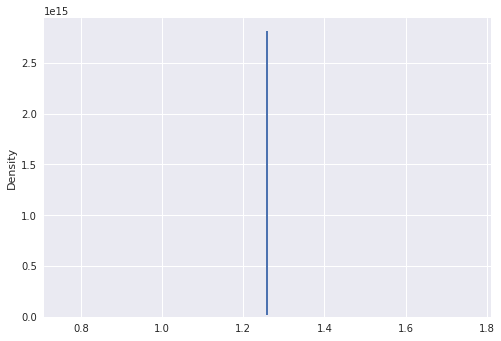

In [78]:
sns.distplot(dummy_preds)

**Chosen Model from grid**

In [79]:
best_model

LGBMRegressor(max_depth=6, n_estimators=200, num_leaves=20, random_state=2023,
              reg_alpha=0.25, reg_lambda=0.75)

In [80]:
best_model.fit(X_train[final_features], y_train)

LGBMRegressor(max_depth=6, n_estimators=200, num_leaves=20, random_state=2023,
              reg_alpha=0.25, reg_lambda=0.75)

In [81]:
best_preds = best_model.predict(X_test[final_features])

In [82]:
mean_absolute_percentage_error(y_test, best_preds)

0.07778531232226053

<AxesSubplot:ylabel='Density'>

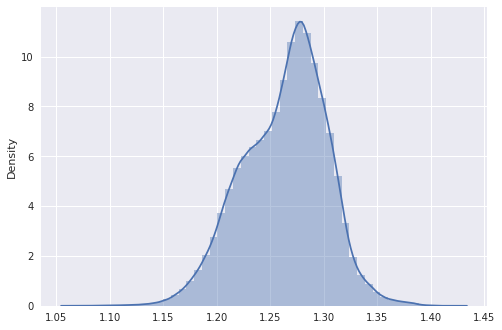

In [83]:
sns.distplot(best_preds)

### LGBM PLOTTING API

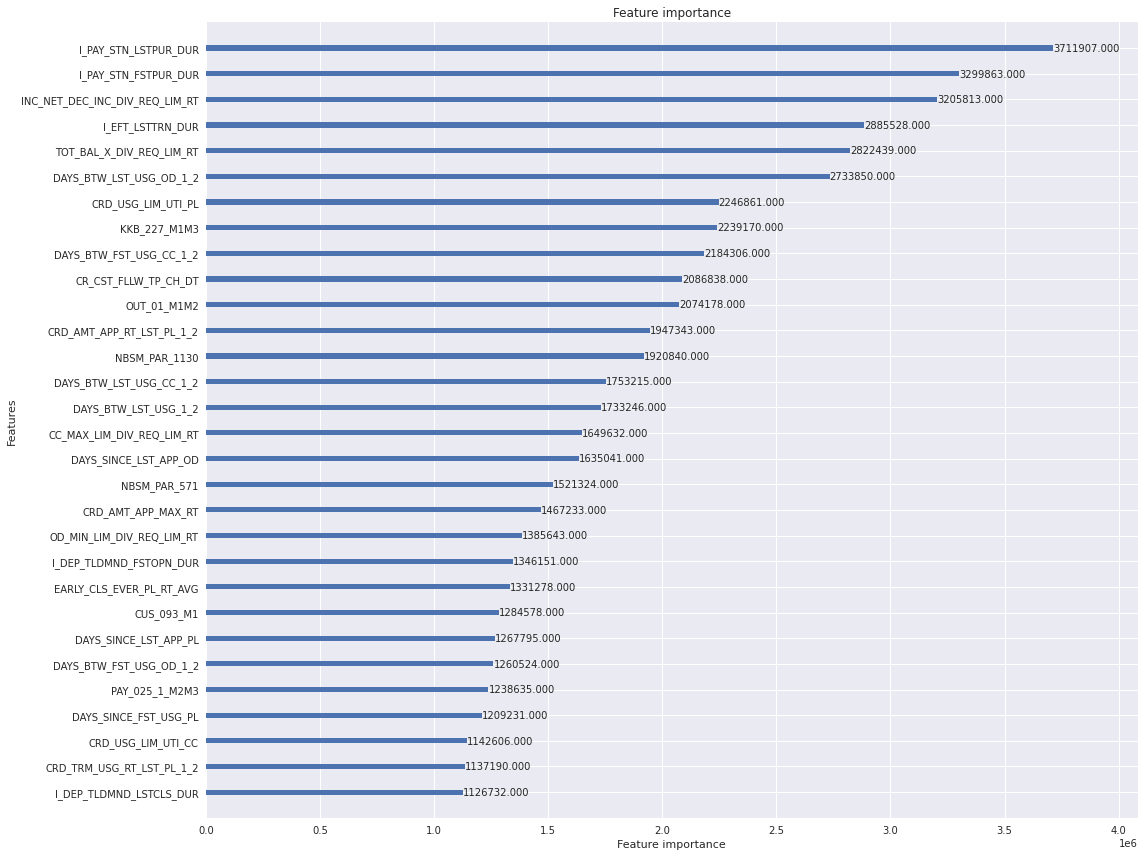

In [74]:
plot_importance(best_model, importance_type = "gain", max_num_features = 30, figsize = (16,12))

plt.tight_layout()

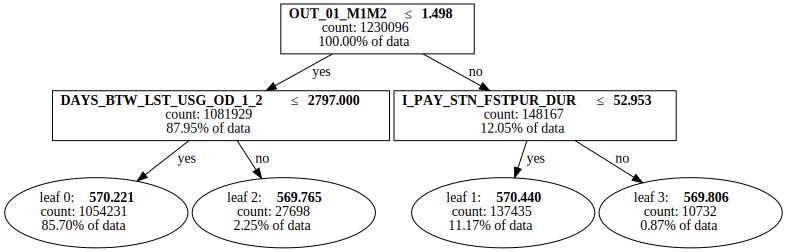

In [75]:
create_tree_digraph(best_model, tree_index = 0, orientation = "vertical",
                   show_info = ["internal_count", "leaf_count", "data_percentage"])

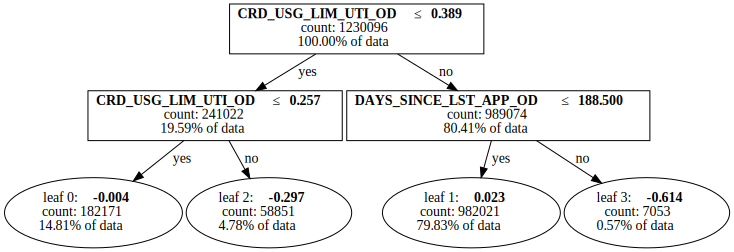

In [76]:
create_tree_digraph(best_model, tree_index = 40, orientation = "vertical",
                   show_info = ["internal_count", "leaf_count", "data_percentage"])

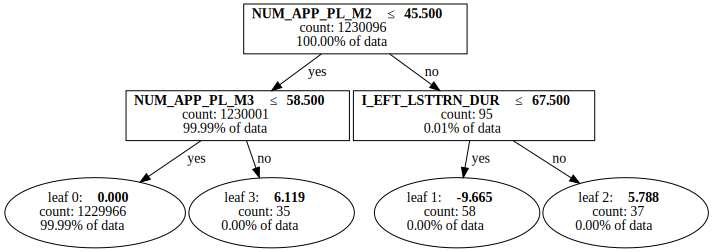

In [77]:
create_tree_digraph(best_model, tree_index = 80, orientation = "vertical",
                   show_info = ["internal_count", "leaf_count", "data_percentage"])

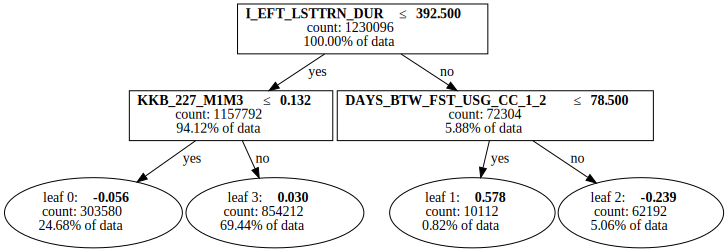

In [78]:
create_tree_digraph(best_model, tree_index = 90, orientation = "vertical",
                   show_info = ["internal_count", "leaf_count", "data_percentage"])

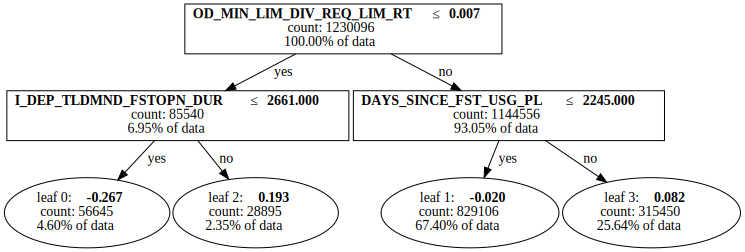

In [79]:
create_tree_digraph(best_model, tree_index = 99, orientation = "vertical",
                   show_info = ["internal_count", "leaf_count", "data_percentage"])